# Baselines and Formulation


In [1]:
import json
import zipfile
import os
import pandas as pd
import numpy as np

In [3]:
%ls

10718_report_baseline.ipynb
Assignment_1_Baselines_and_Formulation.ipynb
Assignment_1_Revision.ipynb
Assignment_2_Chronological_Validation_Splits.ipynb
Assignment_3_Feature_Engineering_and_Modeling.ipynb
README.md
donations.csv
project.csv
resources.csv


In [4]:
full_donations = pd.read_csv("donations.csv")
full_projects = pd.read_csv("project.csv")
# full_essays = pd.read_csv("essays.csv")
full_resources = pd.read_csv("resources.csv")

In [5]:
from datetime import timedelta

import textstat

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

import flair

ModuleNotFoundError: No module named 'textstat'

## Feature Engineering

In [8]:
a = pd.merge(full_projects, full_donations, on=['projectid_str'], how='left')
a['in_4_months'] = (pd.to_datetime(a['donation_timestamp']) - pd.to_datetime(a['date_posted'])) < timedelta(days=120)
a['in_1_months'] = (pd.to_datetime(a['donation_timestamp']) - pd.to_datetime(a['date_posted'])) < timedelta(days=30)
a['donation_1mo'] = a['donation_to_project'].values
values = {'donation_to_project': 0.0}
a = a.fillna(value=values)
a.loc[a['in_4_months'] == False, 'donation_to_project'] = 0.0
a.loc[a['in_1_months'] == False, 'donation_1mo'] = 0.0

donation_in_4_months = a.groupby(['projectid_str'])['donation_to_project'].sum().reset_index(name='donation_in_4_months')
donation_in_1_months = a.groupby(['projectid_str'])['donation_1mo'].sum().reset_index(name='donation_in_1_months')
df = pd.merge(full_projects, donation_in_4_months, on=['projectid_str'], how='left')
df = pd.merge(df, donation_in_1_months, on=['projectid_str'], how='left')

del a

In [12]:
# df['is_fully_funded_after_4_months'] = df['total_price_excluding_optional_support'] <= df['donation_in_4_months']
df['is_fully_funded_after_4_months'] = df['total_asking_price'] <= df['donation_in_4_months']
df['is_fully_funded_after_4_months'].value_counts()
print("Baserate % projects fully funded:", df['is_fully_funded_after_4_months'].mean())

df['pct_funded_1mo'] = df['donation_in_1_months'] / df['total_asking_price']
# df['is_fully_funded_after_1_months'] = df['total_price_excluding_optional_support'] <= df['donation_in_1_months']
df['is_fully_funded_after_1_months'] = df['total_asking_price'] <= df['donation_in_1_months']
df['is_fully_funded_after_1_months'].value_counts()
print("Baserate % projects fully funded 1mo:", df['is_fully_funded_after_1_months'].mean())

Baserate % projects fully funded: 0.5422330097087379
Baserate % projects fully funded 1mo: 0.29775485436893206


In [13]:
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['children_helped_per_dollar'] = df['students_reached']/df['total_price_excluding_optional_support']

KeyError: 'total_price_excluding_optional_support'

In [18]:
from sklearn.preprocessing import OneHotEncoder
one_hot_feature_cols = ['grade_level', 'teacher_prefix', 'school_state']
df = df.replace({'school_charter': {'t': 1, 'f': 0},
                 'school_kipp': {'t': 1, 'f': 0}})

encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding
encoder_df = pd.DataFrame(encoder.fit_transform(df[one_hot_feature_cols]).toarray())
encoder_df.columns = encoder.get_feature_names()
#merge one-hot encoded columns back with original DataFrame
final_X = df.join(encoder_df)
#drop the original columns
final_X = final_X.drop(one_hot_feature_cols, axis=1)

#calculate number of projects and the success rate for each city
num_of_success_projects_per_city = dict(df.groupby(['school_city'])['is_fully_funded_after_4_months'].sum())
num_of_projects_per_city = dict(df.groupby(['school_city']).size())

final_X['num_of_success_projects_in_city']= final_X['school_city'].map(num_of_success_projects_per_city)
final_X['num_of_projects_in_city']= final_X['school_city'].map(num_of_projects_per_city)
final_X['success_rate_in_city']= final_X['num_of_success_projects_in_city'] / final_X['num_of_projects_in_city']
#drop 'school city'
final_X = final_X.drop('school_city', axis=1)

#calculate number of projects and the success rate for each teacher
num_of_success_projects_per_teacher = dict(df.groupby(['teacher_acctid'])['is_fully_funded_after_4_months'].sum())
num_of_projects_per_teacher = dict(df.groupby(['teacher_acctid']).size())

final_X['num_of_success_projects_by_teacher']= final_X['teacher_acctid'].map(num_of_success_projects_per_teacher)
final_X['num_of_projects_by_teacher']= final_X['teacher_acctid'].map(num_of_projects_per_teacher)
final_X['success_rate_by_teacher']= final_X['num_of_success_projects_by_teacher'] / final_X['num_of_projects_by_teacher']
#drop 'teacher_acctid'
final_X = final_X.drop('teacher_acctid', axis=1)
df = final_X

# # row 28-36
feature_cols_projects = ['school_charter', 'school_kipp', 'total_asking_price', 'students_reached'] + list(final_X.columns[-63:])

In [19]:
df.columns

Index(['Unnamed: 0', 'schoolid', 'projectid_str', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_zip', 'school_metro',
       'school_district', 'school_county', 'school_charter', 'school_magnet',
       'school_year_round', 'school_nlns', 'school_kipp',
       'school_charter_ready_promise', 'teacher_teach_for_america',
       'teacher_ny_teaching_fellow', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'fulfillment_labor_materials',
       'total_asking_price', 'total_price_including_optional_support',
       'students_reached', 'eligible_double_your_impact_match',
       'eligible_almost_home_match', 'date_posted', 'entity_id',
       'donation_in_4_months', 'donation_in_1_months',
       'is_fully_funded_after_4_months', 'pct_funded_1mo',
       'is_fully_funded_after_1_months', 'x0_Grades 3-5', 'x0_Grades 6-8',
       'x0_Grades 9-12', 'x0_Grades PreK-2', 'x1_M

In [14]:
full_essays.head()

,projectid,teacher_acctid,title,short_description,need_statement,essay
0,ffffc4f85b60efc5b52347df489d0238,c24011b20fc161ed02248e85beb59a90,iMath,It is imperative that teachers bring technolog...,My students need four iPods.,I am a fourth year fifth grade math teacher. T...
1,ffffac55ee02a49d1abc87ba6fc61135,947066d0af47e0566f334566553dd6a6,Recording Rockin' Readers,Can you imagine having to translate everything...,My students need a camcorder.,Can you imagine having to translate everything...
2,ffff97ed93720407d70a2787475932b0,462270f5d5c212162fcab11afa2623cb,Kindergarten In Need of Important Materials!,It takes a special person to donate to a group...,My students need 17 assorted classroom materia...,Hi. I teach a wonderful group of 4-5 year old ...
3,ffff7266778f71242675416e600b94e1,b9a8f14199e0d8109200ece179281f4f,Let's Find Out!,My Kindergarten students come from a variety o...,"My students need 25 copies of Scholastic's ""Le...",My Kindergarten students come from a variety o...
4,ffff418bb42fad24347527ad96100f81,e885fb002a1d0d39aaed9d21a7683549,Whistle While We Work!,"By using the cross curricular games requested,...",My students need grade level appropriate games...,All work and no play makes school a dull place...


In [15]:
sid = SentimentIntensityAnalyzer()

In [16]:
full_essays.shape

(664098, 6)

In [17]:
sample_essays = full_essays.iloc[:100000]

In [18]:
sample_polarity = sample_essays['title'].astype(str).apply(lambda x: sid.polarity_scores(x))

In [19]:
sample_polarity = sample_essays['short_description'].astype(str).apply(lambda x: sid.polarity_scores(x))

In [20]:
#flair_sentiment= flair.models.TextClassifier.load('en-sentiment')
sid = SentimentIntensityAnalyzer()
for col in ['title','short_description', 'need_statement', 'essay']:
  print(col)
  full_essays[col + '_len'] = full_essays[col].str.len()
  full_essays[col + '_wordlen'] = full_essays[col].astype(str).apply(lambda x: len(x) / len(x.split(' ')))

for col in ['title','short_description']:
  print(col)
  full_essays[col + '_sent'] = full_essays[col].astype(str).apply(lambda x: sid.polarity_scores(x))
  full_essays[col + '_sentnet'] = full_essays[col + '_sent'].apply(lambda x: x['pos'] - x['neg'])
  full_essays[col + '_sentpol'] = full_essays[col + '_sent'].apply(lambda x: x['pos'] + x['neg'])

title
short_description
need_statement
essay
title
short_description


In [21]:
full_essays = full_essays.drop(columns=['teacher_acctid', 'title', 'short_description', 'need_statement', 'essay'])

In [22]:
df = pd.merge(df, full_essays, on=['projectid'], how='left')

In [23]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'donation_in_4_months', 'donation_in_1_months',
       'is_fully_funded_after_4_months', 'pct_funded_1mo',
       'is_fully_funded_after_1_months', 'child

In [29]:
resource_df = full_resources[['resourceid', 'projectid', 'project_resource_type', 'item_unit_price', 'item_quantity']]
resource_df['project_resource_type'] = resource_df['project_resource_type'].astype('str')

# Fill in missing values of item_unit_price & item_quantity
resource_types = np.unique(resource_df['project_resource_type'].tolist())
avg_unit_price = {}
avg_quantity = {}
for rtype in resource_types:
  avg = resource_df.loc[resource_df['project_resource_type'] == rtype]['item_unit_price'].mean()
  avg_unit_price[rtype] = avg
  avg_num = np.floor(resource_df.loc[resource_df['project_resource_type'] == rtype]['item_quantity'].mean())
  avg_quantity[rtype] = avg_num

resource_df['avg_unit_price'] = resource_df.apply(lambda row: avg_unit_price[row['project_resource_type']], axis=1) # This could take a minute to run
resource_df['avg_quantity'] = resource_df.apply(lambda row: avg_quantity[row['project_resource_type']], axis=1)

resource_df['item_unit_price'] = resource_df['item_unit_price'].fillna(resource_df['avg_unit_price'])
resource_df['item_quantity'] = resource_df['item_quantity'].fillna(resource_df['avg_quantity'])

resource_df = resource_df.groupby('projectid').agg({'item_unit_price':'mean', 'item_quantity':'sum'}).reset_index().rename(columns={'item_unit_price':'avg_unit_price', 'item_quantity':'total_item_quantity'})
df = df.merge(resource_df, how='left', on='projectid')

In [161]:
resstat_cols = ['students_reached', 'children_helped_per_dollar', 'primary_focus_area', 'resource_type', 'poverty_level']

text_cols = ['title_len', 'title_sentnet', 'title_sentpol', 'short_description_len', 'short_description_sentnet', 'short_description_sentpol','essay_len', 'need_statement_len']
res_cols = ['avg_unit_price', 'total_item_quantity']
don_cols = ['pct_funded_1mo']
features = resstat_cols + text_cols + res_cols + don_cols + feature_cols_projects
Y = ['is_fully_funded_after_4_months']
df_final = df[['date_posted'] + features + Y]

# Silences a warning that doesn't affect anything
pd.options.mode.chained_assignment = None

for i in ['primary_focus_area', 'resource_type', 'poverty_level']:
  new_addition = pd.get_dummies(df_final[i])
  new_addition.columns = [i + ":" + x.replace(" ","_") for x in new_addition.columns]
  for col_name in new_addition.columns:
    df_final[col_name] = new_addition[col_name].copy(deep=True)
df_final.drop(columns = ['primary_focus_area', 'resource_type', 'poverty_level'], inplace=True)
print(df_final.columns)

Index(['date_posted', 'students_reached', 'children_helped_per_dollar',
       'title_len', 'title_sentnet', 'title_sentpol', 'short_description_len',
       'short_description_sentnet', 'short_description_sentpol', 'essay_len',
       'need_statement_len', 'avg_unit_price', 'total_item_quantity',
       'pct_funded_1mo', 'is_fully_funded_after_4_months',
       'primary_focus_area:Applied_Learning',
       'primary_focus_area:Health_&_Sports',
       'primary_focus_area:History_&_Civics',
       'primary_focus_area:Literacy_&_Language',
       'primary_focus_area:Math_&_Science',
       'primary_focus_area:Music_&_The_Arts',
       'primary_focus_area:Special_Needs', 'resource_type:Books',
       'resource_type:Other', 'resource_type:Supplies',
       'resource_type:Technology', 'resource_type:Trips',
       'resource_type:Visitors', 'poverty_level:high_poverty',
       'poverty_level:highest_poverty', 'poverty_level:low_poverty',
       'poverty_level:moderate_poverty'],
      dtype=

In [162]:
from datetime import datetime

In [163]:
from dateutil.relativedelta import relativedelta

In [164]:
def chron_split_date_ranges(dates, train_length = relativedelta(years=1), val_length = relativedelta(months=1), retrain_length = relativedelta(weeks=2), min_f_col = relativedelta(months=1), min_l_col = relativedelta(months=4)):
  sorted = dates.sort_values()
  first_date = sorted.iloc[0]
  last_date = sorted.iloc[-1]

  split_dates = []

  curr = first_date

  while curr + val_length + train_length + 2 * min_l_col + 2 * min_f_col < last_date:
    train_start = curr + min_f_col
    val_start = train_start + train_length + min_l_col + min_f_col
    
    split_dates.append({
        "train_feature_collection": (curr, train_start),
        "train": (train_start, train_start + train_length),
        "train_label_buffer": (train_start + train_length, train_start + train_length + min_l_col),
        "val_feature_collection": (train_start + train_length + min_l_col, val_start),
        "val": (val_start , val_start + val_length),
        "val_label_buffer": (val_start + val_length, val_start + val_length + min_l_col),
        "train_label": (train_start + min_l_col, train_start + train_length + min_l_col),
        "val_label": (val_start + min_l_col, val_start + val_length + min_l_col)
    })

    curr += retrain_length
  return split_dates

In [165]:
split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))[-1]

In [166]:
split

{'train_feature_collection': (Timestamp('2012-06-08 00:00:00'),
  Timestamp('2012-07-08 00:00:00')),
 'train': (Timestamp('2012-07-08 00:00:00'), Timestamp('2013-07-08 00:00:00')),
 'train_label_buffer': (Timestamp('2013-07-08 00:00:00'),
  Timestamp('2013-11-08 00:00:00')),
 'val_feature_collection': (Timestamp('2013-11-08 00:00:00'),
  Timestamp('2013-12-08 00:00:00')),
 'val': (Timestamp('2013-12-08 00:00:00'), Timestamp('2014-01-08 00:00:00')),
 'val_label_buffer': (Timestamp('2014-01-08 00:00:00'),
  Timestamp('2014-05-08 00:00:00')),
 'train_label': (Timestamp('2012-11-08 00:00:00'),
  Timestamp('2013-11-08 00:00:00')),
 'val_label': (Timestamp('2014-04-08 00:00:00'),
  Timestamp('2014-05-08 00:00:00'))}

In [167]:
def generate_train_val(df, split):
  train = df.loc[(split["train"][0] <= df['date_posted']) & (df['date_posted'] < split["train"][1])].drop(columns=['date_posted']).fillna(0)
  val = df.loc[(split["val"][0] <= df['date_posted']) & (df['date_posted'] < split["val"][1])].drop(columns=['date_posted']).fillna(0)
  return pd.DataFrame(train), pd.DataFrame(val)

In [168]:
train, val = generate_train_val(df_final, split)

In [174]:
train_X = train.drop(columns=['is_fully_funded_after_4_months']).reset_index()
train_Y = train['is_fully_funded_after_4_months'].values
val_X = val.drop(columns=['is_fully_funded_after_4_months']).reset_index()
val_Y = val['is_fully_funded_after_4_months'].values

## Common sense baseline - children helped per dollar

In [234]:
train_select = train_X.sort_values(["children_helped_per_dollar"])
val_select = val_X.sort_values(["children_helped_per_dollar"])

In [235]:
train_select.index.values

array([21816, 18066, 26149, ..., 23619, 61855, 96135], dtype=int64)

In [236]:
train_Y[train_select.index.values]

array([ True,  True,  True, ...,  True,  True,  True])

In [237]:
train_rank = train_select.index.values
val_rank = val_select.index.values
results = []
for threshold in np.linspace(0.01, 1, 100):
    precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
    precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
    recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
    recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
    results.append([precision_train, recall_train, precision_val, recall_val])
results = np.array(results)
print(results[9, 2])

0.6244541484716157


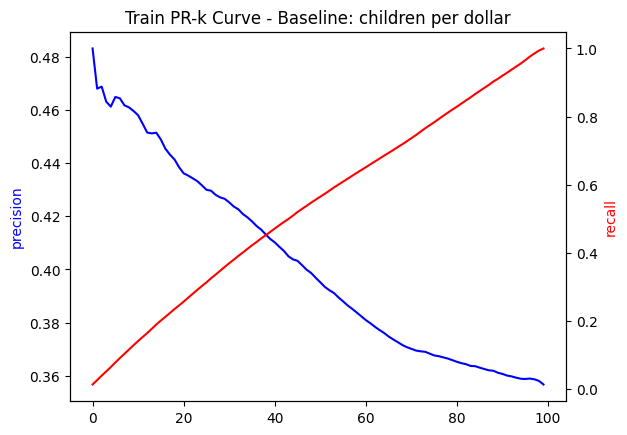

In [241]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,0], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,1], 'r')
plt.ylabel('recall', color='r')
plt.title("Train PR-k Curve - Baseline: children per dollar")
plt.xlabel("Percentage of population selected")
plt.show()

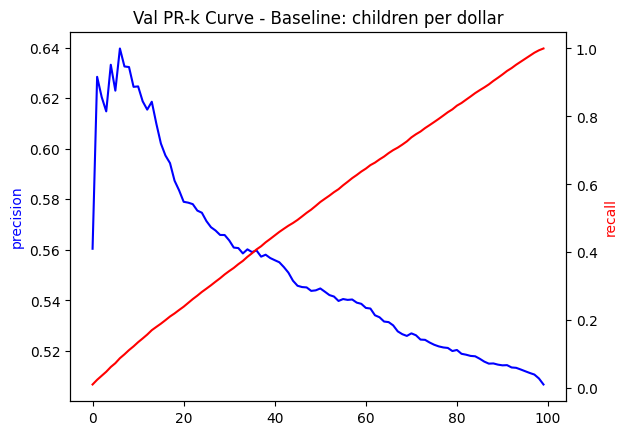

In [240]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,2], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,3], 'r')
plt.ylabel('recall', color='r')
plt.title("Val PR-k Curve - Baseline: children per dollar")
plt.xlabel("Percentage of population selected")
plt.show()

In [186]:
from sklearn.ensemble import RandomForestClassifier as rfc
import time

In [204]:
start = time.time()
model = rfc()
model.fit(train_X, train_Y)
runtime = time.time() - start
print(runtime)

19.403676509857178


In [231]:
train_pred = model.predict_proba(train_X)[:,1]
val_pred = model.predict_proba(val_X)[:,1]

In [232]:
train_rank = np.argsort(train_pred)
val_rank = np.argsort(val_pred)

results = []
for threshold in np.linspace(0.01, 1, 100):
    precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
    precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
    recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
    recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
    results.append([precision_train, recall_train, precision_val, recall_val])
results = np.array(results)
print(results[9, 2])

0.9159388646288209


In [210]:
import matplotlib.pyplot as plt

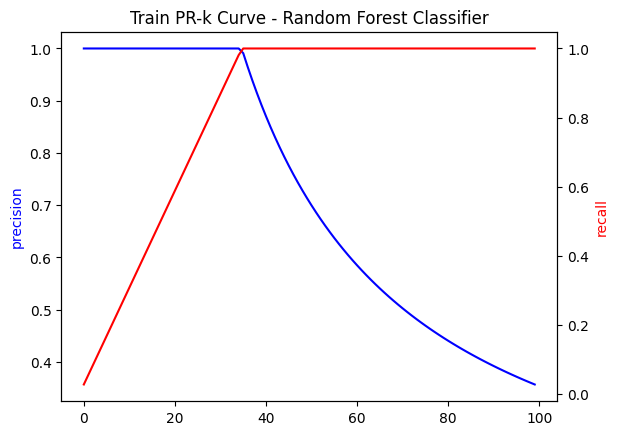

In [211]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,0], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,1], 'r')
plt.ylabel('recall', color='r')
plt.title("Train PR-k Curve - Random Forest Classifier")
plt.xlabel("Percentage of population selected")
plt.show()

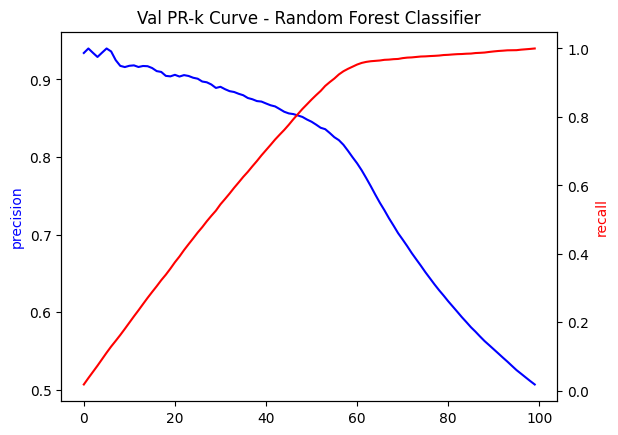

In [212]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,2], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,3], 'r')
plt.ylabel('recall', color='r')
plt.title("Val PR-k Curve - Random Forest Classifier")
plt.show()

In [136]:
train_X.columns[np.argsort(model.feature_importances_)[::-1]]

Index(['donation_in_1_months', 'children_helped_per_dollar', 'avg_unit_price',
       'essay_len', 'need_statement_len', 'short_description_sentnet',
       'short_description_sentpol', 'students_reached', 'title_len',
       'total_item_quantity', 'short_description_len', 'title_sentnet',
       'title_sentpol', 'poverty_level:highest_poverty',
       'resource_type:Technology', 'primary_focus_area:Literacy_&_Language',
       'primary_focus_area:Math_&_Science', 'resource_type:Supplies',
       'poverty_level:high_poverty', 'poverty_level:moderate_poverty',
       'resource_type:Other', 'resource_type:Books',
       'primary_focus_area:Music_&_The_Arts',
       'primary_focus_area:Applied_Learning',
       'primary_focus_area:Special_Needs',
       'primary_focus_area:History_&_Civics', 'poverty_level:low_poverty',
       'primary_focus_area:Health_&_Sports', 'resource_type:Trips',
       'resource_type:Visitors'],
      dtype='object')